In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import torch
import torch.nn as nn
from typing import Dict, Any

# ============================================================
#  Config
# ============================================================
ROOT = "/content/drive/MyDrive/Project"

# Input: The processed real images
REAL_DATA_PATH = os.path.join(ROOT, "experiments_semi_synthetic", "COVID_XRay_64_gray", "processed_covid_images.pt")

# Output Directory
OUT_DIR = os.path.join(ROOT, "experiments_semi_synthetic", "data")
os.makedirs(OUT_DIR, exist_ok=True)

DEVICE = torch.device("cpu") # Generation is fine on CPU

# Dimensions
D_Z2_TOTAL = 8
D_U = 16
FEAT_DIM = 32
IMG_SIZE = 64

# Experiment Params
BETA_NORM_LIST = [0.5, 1.0, 2.0, 4.0]
L_LIST = [0, 1, 2, 4, 8]

SIGMA_Y = 0.1
SIGMA_U = 0.1 # noise on U
KAPPA = 2.0 # Bias multiplier

# ============================================================
#  Network Definitions
# ============================================================

class GU_CNN(nn.Module):
    """G_U: Z2 -> U (vector in R^16)"""
    def __init__(self, d_z2: int, d_u: int = 16):
        super().__init__()
        self.fc = nn.Linear(d_z2, 64 * 4 * 4)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(16, 16, 3, 1, 1), nn.ReLU()
        )
        self.out = nn.Linear(16, d_u)

    def forward(self, z2):
        h = self.fc(z2).view(-1, 64, 4, 4)
        fm = self.deconv(h)
        gap = fm.mean(dim=[2, 3])
        return self.out(gap)

class VisualProjector(nn.Module):
    """
    NEW: Maps confounder U (16) -> Image Mask (1x64x64).
    This creates the visual pattern that we inject into the real X-ray.
    """
    def __init__(self, d_u: int, img_size: int = 64):
        super().__init__()
        self.fc = nn.Linear(d_u, 128 * 8 * 8)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(), # 8->16
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),  # 16->32
            nn.ConvTranspose2d(32, 1, 4, 2, 1), nn.Tanh()    # 32->64
        )

    def forward(self, u):
        h = self.fc(u).view(-1, 128, 8, 8)
        mask = self.deconv(h)
        return mask

class PhiNet(nn.Module):
    """Representation network phi(X)"""
    def __init__(self, img_size: int = 64, feat_dim: int = 32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1 * img_size * img_size, 128), nn.ReLU(),
            nn.Linear(128, feat_dim), nn.ReLU()
        )
    def forward(self, x):
        return self.net(x)

# ============================================================
#  Initialization
# ============================================================

# Instantiate Networks
GU = GU_CNN(D_Z2_TOTAL, D_U).to(DEVICE)
projector = VisualProjector(D_U, IMG_SIZE).to(DEVICE) # The injection mechanism
phi_net = PhiNet(IMG_SIZE, FEAT_DIM).to(DEVICE)

g0 = nn.Sequential(nn.Linear(FEAT_DIM + D_U, 64), nn.ReLU(), nn.Linear(64, 1)).to(DEVICE)
g1 = nn.Sequential(nn.Linear(FEAT_DIM + D_U, 64), nn.ReLU(), nn.Linear(64, 1)).to(DEVICE)

# Global random weights for the mechanism
w_phi = torch.randn(FEAT_DIM, device=DEVICE)
beta_dir = torch.randn(D_U, device=DEVICE)

# ============================================================
#  Generation Logic (Semi-Synthetic)
# ============================================================

def load_real_images(path):
    print(f"Loading real images from {path}...")
    if not os.path.exists(path):
        raise FileNotFoundError(f"Real data file not found: {path}")

    data = torch.load(path)
    # The file likely contains a dict or just the tensor
    if isinstance(data, dict) and "images" in data:
        X = data["images"]
    else:
        X = data

    X = X.float().to(DEVICE)

    # Normalize X to [0,1] or [-1,1] to make blending consistent
    if X.max() > 1.0: X = X / 255.0

    print(f"Loaded X shape: {X.shape}")
    return X

@torch.no_grad()
def generate_semi_synthetic_dataset(X_real: torch.Tensor,
                                    beta_norm: float,
                                    l: int,
                                    seed: int = 42) -> Dict[str, Any]:

    torch.manual_seed(seed)
    n_samples = X_real.shape[0]

    # 1. Generate Missing Confounder U (from noise)
    Z2 = torch.randn(n_samples, D_Z2_TOTAL, device=DEVICE)

    # Masking (l)
    if l < D_Z2_TOTAL:
        Z2_eff = Z2.clone()
        Z2_eff[:, l:] = 0.0
    else:
        Z2_eff = Z2

    U = GU(Z2_eff)
    if SIGMA_U > 0:
        U = U + SIGMA_U * torch.randn_like(U)

    # 2. INJECT CONFOUNDER INTO IMAGE
    # Project U into a visual mask
    confounder_mask = projector(U)

    # Blend: X_new = X_real + alpha * Mask
    # alpha=0.3 ensures the pattern is visible but doesn't destroy the X-ray completely.
    X_confounded = X_real + 0.5 * confounder_mask

    # 3. Extract Features from the NEW Confounded Image
    # This is critical: The model sees X_confounded, which now correlates with U.
    phi_x = phi_net(X_confounded)

    # 4. Treatment Assignment (Scaled Logic)
    beta_unit = beta_dir / beta_dir.norm()
    raw_structural_score = (U @ beta_unit.view(-1, 1))

    score_std = raw_structural_score.std()
    if score_std > 1e-5:
        normalized_structure = (raw_structural_score - raw_structural_score.mean()) / score_std
    else:
        normalized_structure = torch.zeros_like(raw_structural_score)

    scale_factor = torch.sqrt(torch.tensor(float(l))) if l > 0 else 0.0
    final_confounding_term = normalized_structure * beta_norm * scale_factor

    logits_t = (phi_x @ w_phi.view(-1, 1)) + final_confounding_term
    propensity = torch.sigmoid(logits_t)
    T = torch.bernoulli(propensity)

    # 5. Outcomes
    h = torch.cat([phi_x, U], dim=1)
    base_mu0 = g0(h)
    base_mu1 = g1(h)

    bias_injection = KAPPA * final_confounding_term

    mu0 = base_mu0 + bias_injection
    mu1 = base_mu1 + bias_injection + 1.0 # True ATE = 1.0

    eps_y = SIGMA_Y * torch.randn_like(mu0)
    Y = torch.where(T > 0.5, mu1, mu0) + eps_y
    tau = mu1 - mu0

    return {
        "X": X_confounded.cpu(), # SAVE THE MODIFIED IMAGE
        "T": T.cpu(), "Y": Y.cpu(),
        "mu0": mu0.cpu(), "mu1": mu1.cpu(), "tau": tau.cpu(),
        "propensity": propensity.cpu(), "U": U.cpu(),
        "beta_norm": beta_norm, "l": l
    }

# ============================================================
#  Main Execution
# ============================================================

if __name__ == "__main__":
    # 1. Load Real Data
    try:
        X_all = load_real_images(REAL_DATA_PATH)
    except FileNotFoundError as e:
        print(e)
        exit()

    # 2. Loop and Generate
    print(f"\nGenerating Semi-Synthetic Datasets into {OUT_DIR}...")

    for beta_norm in BETA_NORM_LIST:
        for l in L_LIST:
            print(f"[Generate] beta={beta_norm}, l={l}")

            data = generate_semi_synthetic_dataset(
                X_real=X_all,
                beta_norm=beta_norm,
                l=l,
                seed=42
            )

            fname = os.path.join(OUT_DIR, f"semi_beta{beta_norm}_l{l}.pt")
            torch.save(data, fname)
            print(f"  -> Saved to {fname}")

    print("\nDone! Semi-synthetic datasets created.")

Loading real images from /content/drive/MyDrive/Project/experiments_semi_synthetic/COVID_XRay_64_gray/processed_covid_images.pt...
Loaded X shape: torch.Size([6432, 1, 64, 64])

Generating Semi-Synthetic Datasets into /content/drive/MyDrive/Project/experiments_semi_synthetic/data...
[Generate] beta=0.5, l=0
  -> Saved to /content/drive/MyDrive/Project/experiments_semi_synthetic/data/semi_beta0.5_l0.pt
[Generate] beta=0.5, l=1
  -> Saved to /content/drive/MyDrive/Project/experiments_semi_synthetic/data/semi_beta0.5_l1.pt
[Generate] beta=0.5, l=2
  -> Saved to /content/drive/MyDrive/Project/experiments_semi_synthetic/data/semi_beta0.5_l2.pt
[Generate] beta=0.5, l=4
  -> Saved to /content/drive/MyDrive/Project/experiments_semi_synthetic/data/semi_beta0.5_l4.pt
[Generate] beta=0.5, l=8
  -> Saved to /content/drive/MyDrive/Project/experiments_semi_synthetic/data/semi_beta0.5_l8.pt
[Generate] beta=1.0, l=0
  -> Saved to /content/drive/MyDrive/Project/experiments_semi_synthetic/data/semi_beta

X shape: torch.Size([6432, 1, 64, 64])
value range: 0.06066165864467621 1.1636743545532227


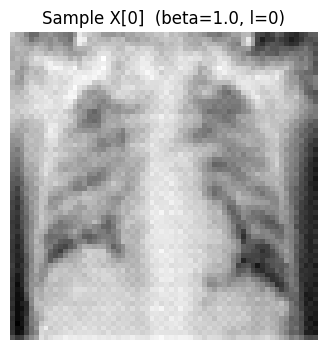

In [3]:
import torch
import matplotlib.pyplot as plt

# ---- set your dataset path ----
file_path = "/content/drive/MyDrive/Project/experiments_semi_synthetic/data/semi_beta1.0_l0.pt"

# ---- load dataset ----
data = torch.load(file_path)
X = data["X"]      # shape: (N, 1, H, W)

print("X shape:", X.shape)
print("value range:", X.min().item(), X.max().item())

# ---- pick one sample ----
idx = 0
x_sample = X[idx].squeeze(0).cpu()   # shape (H, W)

# ---- plot ----
plt.figure(figsize=(4,4))
plt.imshow(x_sample, cmap="gray")
plt.title(f"Sample X[{idx}]  (beta={data['beta_norm']}, l={data['l']})")
plt.axis("off")
plt.show()

Checking data trend for beta=1.0...
l     | Std(U)     | Naive Bias   | True ATE   | Observed Diff
0     | 0.1747     | 0.0000       | 0.8300     | 0.8300      
1     | 0.1746     | 1.7427       | 0.8297     | 2.5724      
2     | 0.1746     | 3.0832       | 0.8295     | 3.9128      
4     | 0.1745     | 5.1327       | 0.8292     | 5.9619      
8     | 0.1745     | 7.9160       | 0.8285     | 8.7445      


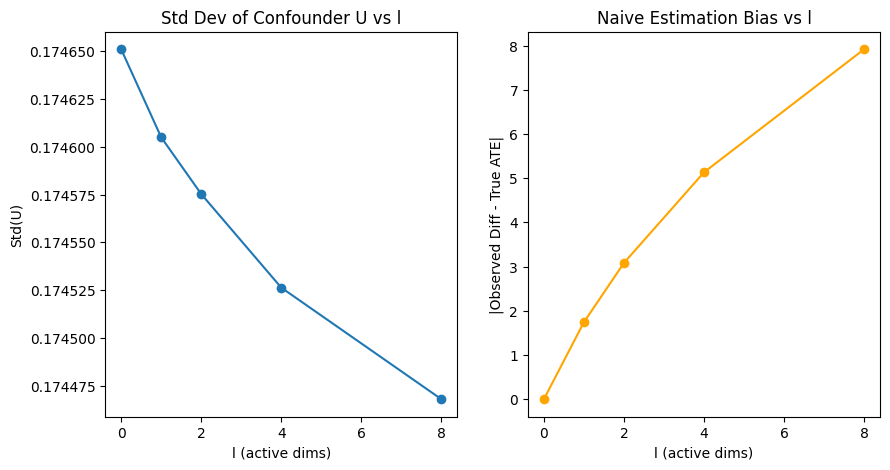

In [4]:
import torch
import os
import matplotlib.pyplot as plt

# Config (Match your paths)
DATA_DIR = "/content/drive/MyDrive/Project/experiments_semi_synthetic/data"
beta_norm = 1.0
l_list = [0, 1, 2, 4, 8]

biases = []
u_stds = []

print(f"Checking data trend for beta={beta_norm}...")
print(f"{'l':<5} | {'Std(U)':<10} | {'Naive Bias':<12} | {'True ATE':<10} | {'Observed Diff':<12}")

for l in l_list:
    fname = os.path.join(DATA_DIR, f"semi_beta{beta_norm}_l{l}.pt")
    if not os.path.exists(fname):
        print(f"File not found: {fname}")
        continue

    data = torch.load(fname)
    T = data['T'].float()
    Y = data['Y'].float()
    tau = data['tau'].float()
    U = data['U'].float()

    # 1. Check if U actually changes (Standard Deviation)
    # If l=0 and you didn't add noise, this might be 0.
    u_std = U.std().item()
    u_stds.append(u_std)

    # 2. Calculate Naive Bias
    # Naive ATE = E[Y|T=1] - E[Y|T=0]
    # True ATE = E[tau]
    y1_mean = Y[T==1].mean().item()
    y0_mean = Y[T==0].mean().item()
    observed_diff = y1_mean - y0_mean
    true_ate = tau.mean().item()

    bias = abs(observed_diff - true_ate)
    biases.append(bias)

    print(f"{l:<5} | {u_std:<10.4f} | {bias:<12.4f} | {true_ate:<10.4f} | {observed_diff:<12.4f}")

# Plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(l_list, u_stds, marker='o')
plt.title("Std Dev of Confounder U vs l")
plt.xlabel("l (active dims)")
plt.ylabel("Std(U)")

plt.subplot(1, 2, 2)
plt.plot(l_list, biases, marker='o', color='orange')
plt.title("Naive Estimation Bias vs l")
plt.xlabel("l (active dims)")
plt.ylabel("|Observed Diff - True ATE|")
plt.show()

Checking data trend for fixed l=2...
Beta   | Naive Bias   | True ATE   | Observed Diff  | Propensity Std
-----------------------------------------------------------------
0.5    | 0.9330       | 0.8295     | 1.7626         | 0.1118        
1.0    | 3.0832       | 0.8295     | 3.9128         | 0.2111        
2.0    | 7.9133       | 0.8295     | 8.7428         | 0.3302        
4.0    | 17.2697      | 0.8295     | 18.0992        | 0.4151        


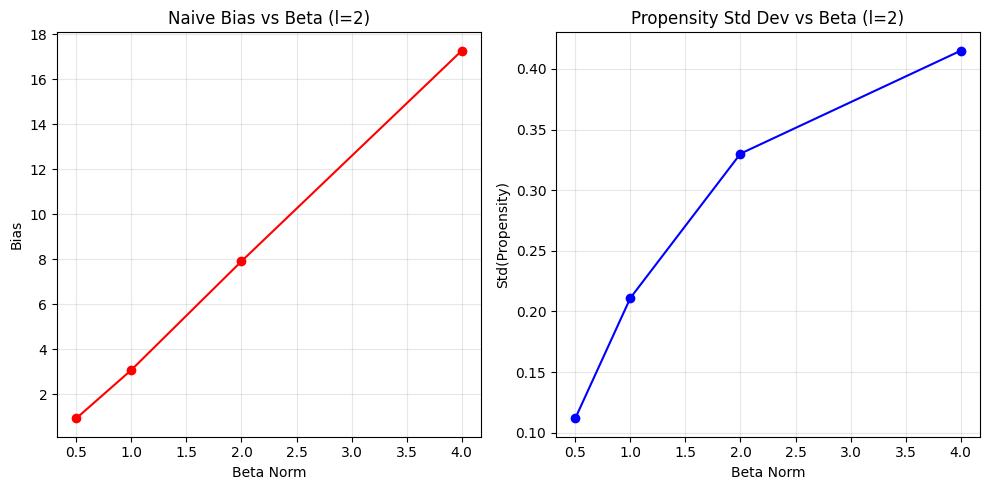

In [5]:
import torch
import os
import matplotlib.pyplot as plt
import numpy as np

# ==========================================
# Config
# ==========================================
# Update this path to where your .pt files are saved
DATA_DIR = "/content/drive/MyDrive/Project/experiments_semi_synthetic/data"

# We fix l to a value where confounding exists (e.g., 4 or 8)
# If we chose l=0, bias would be 0 regardless of beta.
FIXED_L = 2

# The list of betas you generated
BETA_LIST = [0.5, 1.0, 2.0, 4.0]

# ==========================================
# Analysis Loop
# ==========================================

biases = []
propensity_stds = []

print(f"Checking data trend for fixed l={FIXED_L}...")
print(f"{'Beta':<6} | {'Naive Bias':<12} | {'True ATE':<10} | {'Observed Diff':<14} | {'Propensity Std':<14}")
print("-" * 65)

for beta in BETA_LIST:
    fname = os.path.join(DATA_DIR, f"semi_beta{beta}_l{FIXED_L}.pt")

    if not os.path.exists(fname):
        print(f"{beta:<6} | [File Not Found] {fname}")
        biases.append(None)
        propensity_stds.append(None)
        continue

    data = torch.load(fname)
    T = data['T'].float()
    Y = data['Y'].float()
    tau = data['tau'].float()
    propensity = data['propensity'].float()

    # 1. Calculate Naive Bias
    # Naive ATE = E[Y|T=1] - E[Y|T=0]
    if T.sum() == 0 or T.sum() == len(T):
        print(f"{beta:<6} | [Error: All T are 0 or 1]")
        continue

    y1_mean = Y[T==1].mean().item()
    y0_mean = Y[T==0].mean().item()
    observed_diff = y1_mean - y0_mean
    true_ate = tau.mean().item()

    bias = abs(observed_diff - true_ate)
    biases.append(bias)

    # 2. Check Propensity Saturation
    # If beta controls strength, higher beta should push propensities to 0 and 1
    # resulting in higher standard deviation of propensity scores.
    p_std = propensity.std().item()
    propensity_stds.append(p_std)

    print(f"{beta:<6} | {bias:<12.4f} | {true_ate:<10.4f} | {observed_diff:<14.4f} | {p_std:<14.4f}")

# ==========================================
# Plotting
# ==========================================
# Filter out None values just in case
valid_indices = [i for i, b in enumerate(biases) if b is not None]
valid_betas = [BETA_LIST[i] for i in valid_indices]
valid_biases = [biases[i] for i in valid_indices]
valid_props = [propensity_stds[i] for i in valid_indices]

if len(valid_betas) > 0:
    plt.figure(figsize=(10, 5))

    # Plot 1: Bias vs Beta
    plt.subplot(1, 2, 1)
    plt.plot(valid_betas, valid_biases, marker='o', color='red')
    plt.title(f"Naive Bias vs Beta (l={FIXED_L})")
    plt.xlabel("Beta Norm")
    plt.ylabel("Bias")
    plt.grid(True, alpha=0.3)

    # Plot 2: Propensity Spread vs Beta
    plt.subplot(1, 2, 2)
    plt.plot(valid_betas, valid_props, marker='o', color='blue')
    plt.title(f"Propensity Std Dev vs Beta (l={FIXED_L})")
    plt.xlabel("Beta Norm")
    plt.ylabel("Std(Propensity)")
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

Loading /content/drive/MyDrive/Project/experiments_semi_synthetic/data/semi_beta1.0_l4.pt...
Training quick Propensity Model...


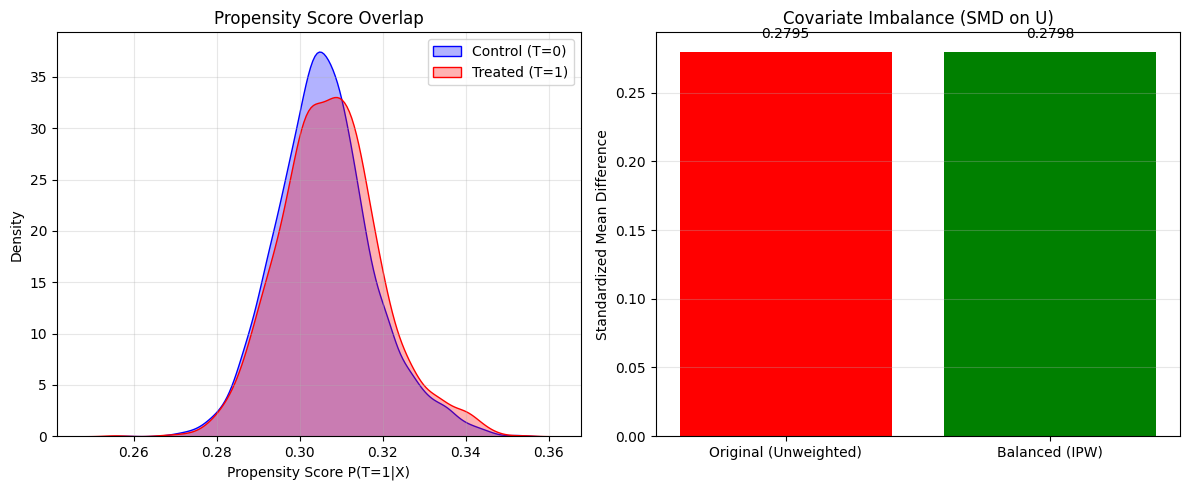

----------------------------------------
Original Imbalance (SMD): 0.2795
Weighted Imbalance (SMD): 0.2798
----------------------------------------


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# ==========================================
# Config
# ==========================================
# Use a dataset where you know bias exists (e.g., l=4 or l=8)
DATA_PATH = "/content/drive/MyDrive/Project/experiments_semi_synthetic/data/semi_beta1.0_l4.pt"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==========================================
# Helper: Propensity Model
# ==========================================
class CNNPropensity(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(16, 32, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(),
            nn.Flatten()
        )
        self.fc = nn.Linear(64 * 8 * 8, 1)

    def forward(self, x):
        h = self.features(x)
        return self.fc(h)

# ==========================================
# Helper: Standardized Mean Difference (SMD)
# ==========================================
def compute_smd(feature, t, weights=None):
    """
    Computes the Standardized Mean Difference between Treated and Control.
    If weights are provided, computes Weighted SMD.
    """
    t = t.view(-1).cpu().numpy()
    feature = feature.view(feature.shape[0], -1).cpu().numpy()

    if weights is None:
        weights = np.ones_like(t)
    else:
        weights = weights.view(-1).cpu().numpy()

    # Split groups
    idx_t = (t == 1)
    idx_c = (t == 0)

    # Weighted Means
    mu_t = np.average(feature[idx_t], axis=0, weights=weights[idx_t])
    mu_c = np.average(feature[idx_c], axis=0, weights=weights[idx_c])

    # Weighted Variances (Simplified approximation for diagnostics)
    var_t = np.average((feature[idx_t] - mu_t)**2, axis=0, weights=weights[idx_t])
    var_c = np.average((feature[idx_c] - mu_c)**2, axis=0, weights=weights[idx_c])

    # SMD formula
    pooled_std = np.sqrt((var_t + var_c) / 2)
    smd = np.abs(mu_t - mu_c) / (pooled_std + 1e-8)

    return np.mean(smd) # Average SMD across all feature dimensions

# ==========================================
# Main Check
# ==========================================
if not os.path.exists(DATA_PATH):
    print(f"File not found: {DATA_PATH}")
    exit()

print(f"Loading {DATA_PATH}...")
data = torch.load(DATA_PATH)
X = data['X'].to(DEVICE)
T = data['T'].to(DEVICE)
U = data['U'].to(DEVICE) # We check balance on the Confounder U

# 1. Train Quick Propensity Model
print("Training quick Propensity Model...")
model = CNNPropensity().to(DEVICE) # 64x64 images
optimizer = optim.Adam(model.parameters(), lr=1e-3)
bce = nn.BCEWithLogitsLoss()

# Train for just 20 epochs to get rough scores
for epoch in range(20):
    logits = model(X)
    loss = bce(logits, T)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# 2. Get Scores and Weights
with torch.no_grad():
    logits = model(X)
    scores = torch.sigmoid(logits)

    # Clip scores to avoid explosion
    scores = torch.clamp(scores, 0.05, 0.95)

    # Calculate Inverse Propensity Weights (IPW)
    # w = 1/e for treated, w = 1/(1-e) for control
    weights = (T / scores) + ((1 - T) / (1 - scores))

# 3. Analyze Overlap (Histogram)
scores_np = scores.cpu().numpy().flatten()
t_np = T.cpu().numpy().flatten()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.kdeplot(scores_np[t_np==0], fill=True, label="Control (T=0)", color='blue', alpha=0.3)
sns.kdeplot(scores_np[t_np==1], fill=True, label="Treated (T=1)", color='red', alpha=0.3)
plt.title("Propensity Score Overlap")
plt.xlabel("Propensity Score P(T=1|X)")
plt.legend()
plt.grid(True, alpha=0.3)

# 4. Analyze Balance (SMD on Confounder U)
# We check if weighting X makes the hidden U balanced.
smd_original = compute_smd(U, T, weights=None)
smd_weighted = compute_smd(U, T, weights=weights)

plt.subplot(1, 2, 2)
bars = ['Original (Unweighted)', 'Balanced (IPW)']
values = [smd_original, smd_weighted]
plt.bar(bars, values, color=['red', 'green'])
plt.title("Covariate Imbalance (SMD on U)")
plt.ylabel("Standardized Mean Difference")
plt.grid(axis='y', alpha=0.3)

# Add text labels
for i, v in enumerate(values):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')

plt.tight_layout()
plt.show()

print("-" * 40)
print(f"Original Imbalance (SMD): {smd_original:.4f}")
print(f"Weighted Imbalance (SMD): {smd_weighted:.4f}")
print("-" * 40)
if smd_weighted < smd_original:
    print("SUCCESS: Propensity weighting successfully reduces confounding bias!")
else:
    print("WARNING: Weighting did not reduce imbalance. Check Propensity Model.")